MASSACHUSETTS INSTITUTE OF TECHNOLOGY<br>
SYSTEM DESIGN & MANAGEMENT<br>
Author: R. Chadwick Holmes<br>
Date: December 5, 2021<br><br>

Script Purpose:<br>
Prepare geodetic strain rate data by cropping to study area and calculating magnitude.
<br><br>


In [1]:
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely
!pip install dataprep --no-binary dataprep

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:13 ht

# Strain Rate Calculations

In [2]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor

from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

import numpy as np

### Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = r'/content/drive/MyDrive/Colab Notebooks/Data'

Mounted at /content/drive


### Load data into geopandas dataframe

In [6]:
# read data into pandas dataframe
data_folder = Path(path)
data_file = r'GSRM_strain.txt'

In [7]:
srdf = pd.read_csv(data_folder / data_file,
                   delim_whitespace=True,
                   header=24)
srdf.rename(columns={'#lat':'Latitude','long':'Longitude'},inplace=True)

In [8]:
gdf = gpd.GeoDataFrame(srdf, 
                       geometry=gpd.points_from_xy(srdf.Longitude, srdf.Latitude),
                       crs = {'init': 'epsg:4326'})

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [9]:
print(gpd.__version__)

0.10.2+14.g027cac0


### Restrict data to AOI region

In [10]:
print(gdf.shape)
xmin,xmax,ymin,ymax = [-109.25, -102.75, 31.00, 37.25]
polygon = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=gdf.crs)

aoi_mask = gdf.within(poly_gdf.loc[0,'geometry'])
gdf = gdf.loc[aoi_mask].reset_index(drop=True)
print(gdf.shape)
print(gdf.head())

(6300000, 12)
(3968, 12)
   Latitude  Longitude  exx  eyy  ...   e1   e2  azi_e1                     geometry
0     31.05    -109.15  0.4  0.3  ...  1.1 -0.4   132.2  POINT (-109.15000 31.05000)
1     31.05    -109.05  0.4  0.3  ...  1.1 -0.4   132.4  POINT (-109.05000 31.05000)
2     31.05    -108.95  0.4  0.3  ...  1.1 -0.4   132.5  POINT (-108.95000 31.05000)
3     31.05    -108.85  0.4  0.3  ...  1.1 -0.4   132.7  POINT (-108.85000 31.05000)
4     31.05    -108.75  0.4  0.3  ...  1.1 -0.4   133.0  POINT (-108.75000 31.05000)

[5 rows x 12 columns]


In [11]:
# clean up large files
del srdf, aoi_mask

### Calculate Second Invariant (Magnitude)

In [12]:
gdf['Magnitude'] = np.sqrt(gdf['exx']**2+gdf['eyy']**2+2*gdf['exy']**2)
gdf.head()

,Latitude,Longitude,exx,eyy,exy,vorticity,RL-NLC,LL-NLC,e1,e2,azi_e1,geometry,Magnitude
0,31.05,-109.15,0.4,0.3,-0.7,-0.012,11.2,73.1,1.1,-0.4,132.2,POINT (-109.15000 31.05000),1.109054
1,31.05,-109.05,0.4,0.3,-0.7,-0.013,11.8,72.9,1.1,-0.4,132.4,POINT (-109.05000 31.05000),1.109054
2,31.05,-108.95,0.4,0.3,-0.7,-0.014,12.4,72.7,1.1,-0.4,132.5,POINT (-108.95000 31.05000),1.109054
3,31.05,-108.85,0.4,0.3,-0.7,-0.015,13.1,72.4,1.1,-0.4,132.7,POINT (-108.85000 31.05000),1.109054
4,31.05,-108.75,0.4,0.3,-0.7,-0.015,13.7,72.3,1.1,-0.4,133.0,POINT (-108.75000 31.05000),1.109054


In [13]:
outfile = 'strain_rate_NM_aoi.csv'

In [14]:
gdf.to_csv(data_folder / outfile)

In [15]:
gdf = pd.read_csv(data_folder / outfile)

### plot with cartopy

In [18]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy

myprojection = ccrs.PlateCarree()
#myprojection = ccrs.Geodetic()

xmin,xmax,ymin,ymax = [-109.25, -102.75, 31.00, 37.25]
extent = [xmin,xmax,ymin,ymax]

def createBasemap():
    expl_area = data_folder / 'Exploration_area.shp'
    expl_area_feat = ShapelyFeature(Reader(expl_area).geometries(), crs=myprojection, edgecolor='black')

    rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')
    stamen_terrain = cimgt.Stamen('terrain-background')

    # generate plot of NM with river and stock image
    plt.figure(figsize=(20,12))
    ax = plt.axes(projection=myprojection)

    # Add the Stamen data at zoom level 9.
    #ax.stock_img()
    ax.add_image(stamen_terrain, 9)
    
    ax.add_feature(cartopy.feature.STATES)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')
    ax.add_feature(expl_area_feat, facecolor='None', edgecolor='r', linewidth=2, alpha = 0.5)

    ax.set_extent(extent,crs=myprojection)
    
    return ax

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naci

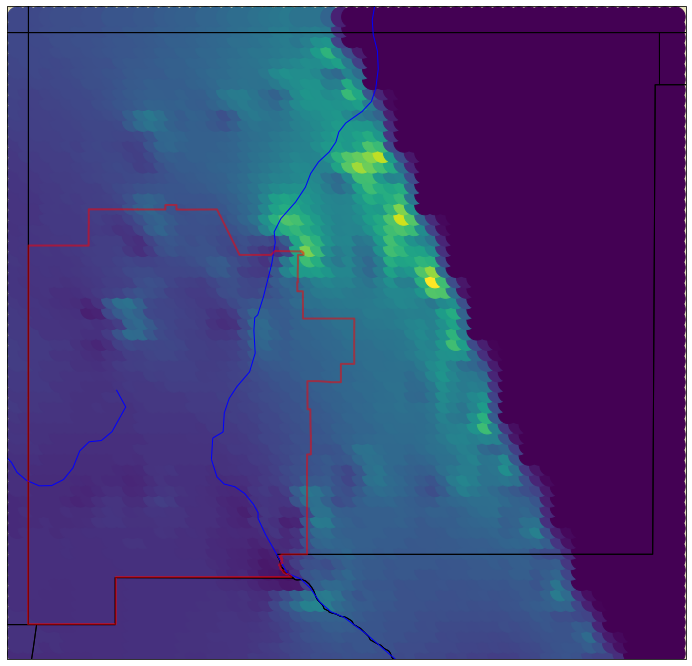

In [19]:
ax = createBasemap();
#ax.plot_surface(gdf.Longitude, gdf.Latitude, gdf.Magnitude, shading='auto')
ax.scatter(gdf.Longitude,
           gdf.Latitude,
           s=400,
           c=((gdf.Magnitude-np.mean(gdf.Magnitude))/np.std(gdf.Magnitude)),
           alpha=1.0,
           transform=myprojection);
plt.show()